In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl

In [3]:
wine_df = pd.read_csv('data/wine.csv')
#dropping catagorical features, quality and type
wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,2
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,2
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,2
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


In [4]:
df = pd.concat([wine_df,pd.get_dummies(wine_df.quality,prefix='quality'),pd.get_dummies(wine_df.wine_type,prefix='wine_type')],axis=1)

In [5]:
df = df.drop(['quality','wine_type'],axis=1)

In [6]:
wine_df.wine_type.value_counts()

2    4898
1    1599
Name: wine_type, dtype: int64

In [7]:
wine_df.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [7]:
dfshape = df.shape

In [8]:
df.iloc[0,4]

0.045

Need to figure out some random locs to sub sample, we can do this based on a percentage of rows/colums or total points

In [8]:
def random_loc(data_frame_shape):
    col = np.random.randint(0,data_frame_shape[1])
    row = np.random.randint(0,data_frame_shape[0])
    return row,col

In [14]:
random_loc(dfshape)

(1283, 3)

In [15]:
random_loc(dfshape)[0]

2001

In [16]:
df.iloc[random_loc(dfshape)[0],random_loc(dfshape)[1]]

0

In [9]:
def induce_missingness(dataframe,percent):
    np.random.seed(999)
    num2nan = int(dataframe.shape[0]*dataframe.shape[1]*percent)
    
    dfout = dataframe.copy()
    
    for _ in range(num2nan): 
        
        randloc = random_loc(dataframe.shape)
        
        while dfout.iloc[randloc[0],randloc[1]] == np.nan:
            randloc = random_loc(dataframe.shape)
            
        dfout.iloc[randloc[0],randloc[1]] = np.nan
        
        
    
    return dfout 
    

In [10]:
dout = induce_missingness(df,0.01)

In [11]:
df.shape

(6497, 20)

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()
scaler.fit(df.to_numpy())
df_scaled = pd.DataFrame(data=scaler.transform(df.to_numpy()),columns=df.columns)

In [14]:
col_type = pd.DataFrame(data=np.array([np.nan]*20).reshape(1,20),columns=df_scaled.columns)
for col in df_scaled.columns:
    #print(col,len(df_scaled[col].unique()))
    
    if len(df_scaled[col].unique()) < 3:
        col_type[col] = 'cat'
    else:
        col_type[col] = 'num'
col_type.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,num,num,num,num,num,num,num,num,num,num,num,cat,cat,cat,cat,cat,cat,cat,cat,cat


In [15]:
from Models.simple_VAE import VAE
import argparse
import torch
import torch.utils.data 
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [16]:
def RMSE(darray,recon):
    return np.sqrt(np.mean(np.square(darray - recon)))

In [17]:
def train_model(data_array,model_in,
                optimizer_in,device_in,epochs=50,batch_size=125,mask_in=None):
    
    
    data_iter = DataLoader(dtensor,batch_size=batch_size, shuffle=False)
    mask_iter = DataLoader(torch.FloatTensor(mask_in),batch_size=batch_size, shuffle=False)
    model_in.train()
    
    
    

    loss_store = []

    for epoch in range(epochs): 
        for idx, (batch,mask) in enumerate(zip(data_iter,mask_iter)):
        
        
            batch_in = batch.float()
            optimizer_in.zero_grad()
        
            drecon,mu,log_var =  model_in.forward(batch_in)
            
            loss = model_in.loss((1-mask)*drecon, (1-mask)*batch_in)
            loss.backward()
            optimizer_in.step()


        loss_store.append(loss.item())

    
    plt.plot(loss_store)
    plt.show()

    model_in.eval()
    drecon,mu,log_var =  model(dtensor)
    recon_array = drecon.detach().numpy()
    input_array = dtensor.detach().numpy()#dtensor.detach().numpy()

    return RMSE(input_array,recon_array),model_in

In [149]:
test_recon,mu_test,log_var = model(torch.FloatTensor(test))
z = model.reparam(mu_test,log_var).detach().numpy()

NameError: name 'test' is not defined

In [309]:

z_embedded = TSNE(n_components=2).fit_transform(z)
#>>> X_embedded.shape
#print(z_embedded)

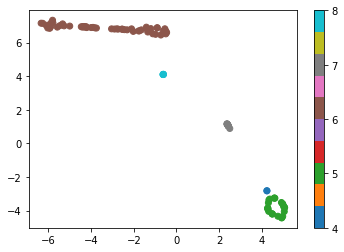

In [335]:
colours = wine_df['quality'].iloc[:100].to_numpy()
bounds = list(set(wine_df['quality'].iloc[:100].to_numpy()))
sc = plt.scatter(z_embedded[:,0],z_embedded[:,1],c=colours, cmap='tab10')
plt.colorbar(sc, ticks=bounds)
plt.show()

In [18]:
def plot_latent_space(data_in,model_in,labels):
    """"""
    test_recon3,mu_out,log_out = model_in(torch.FloatTensor(data_in))
    zout = model_in.reparam(mu_out,log_out).detach().numpy()
    
    z_emb  = TSNE(n_components=2).fit_transform(zout)
    
    colours = labels.to_numpy()
    bounds = list(set(labels.to_numpy()))
    sc = plt.scatter(z_emb[:,0],z_emb[:,1],c=colours, cmap='tab10')
    plt.colorbar(sc, ticks=bounds)
    plt.show()

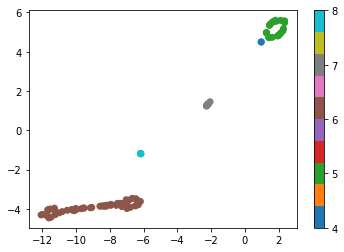

In [343]:
plot_latent_space(test,model,wine_df['quality'].iloc[:100])

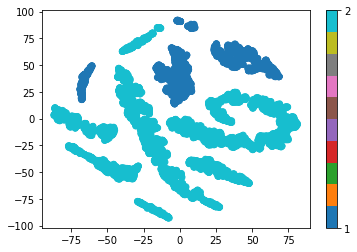

In [346]:
plot_latent_space(darray[100:,:],model,wine_df['wine_type'].iloc[100:]) 

In [18]:
df_shuffle = df_scaled.sample(frac=1,random_state=10)
df_test    = df_shuffle.iloc[:,:].reset_index(drop=True)
df_train   = df_shuffle.iloc[:-1200,:].reset_index(drop=True)
#roughly 20% train test split

In [19]:
df_test.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,0.214876,0.373333,0.125980,0.018405,0.119601,0.045139,0.057604,0.188476,0.674419,0.247191,0.260870,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.231405,0.226667,0.077758,0.187117,0.058140,0.086806,0.350230,0.204471,0.403101,0.140449,0.144928,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.148760,0.280000,0.053647,0.026074,0.066445,0.055556,0.214286,0.126999,0.705426,0.230337,0.724638,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.925620,0.086667,0.264617,0.024540,0.109635,0.031250,0.041475,0.250337,0.271318,0.348315,0.173913,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.231405,0.073333,0.596142,0.009202,0.187708,0.152778,0.283410,0.125072,0.286822,0.050562,0.101449,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [20]:
torch.manual_seed(999)

In [21]:
df_test_with_nans = induce_missingness(df_test,0.2)

In [22]:
df_test_with_nans.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,0.214876,0.373333,0.125980,0.018405,0.119601,0.045139,0.057604,0.188476,NaN,0.247191,0.260870,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0
1,0.231405,0.226667,0.077758,0.187117,0.058140,0.086806,0.350230,0.204471,0.403101,0.140449,0.144928,NaN,0.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0
2,0.148760,0.280000,0.053647,0.026074,0.066445,0.055556,0.214286,0.126999,NaN,0.230337,NaN,0.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0
3,0.925620,0.086667,0.264617,0.024540,0.109635,0.031250,0.041475,0.250337,0.271318,0.348315,NaN,0.0,NaN,NaN,0.0,1.0,NaN,0.0,1.0,0.0
4,0.231405,0.073333,0.596142,NaN,0.187708,0.152778,NaN,0.125072,0.286822,0.050562,0.101449,0.0,0.0,NaN,1.0,0.0,0.0,NaN,NaN,1.0


In [23]:
from sklearn.impute import MissingIndicator
indicator = MissingIndicator()
indicator.fit(df_test_with_nans)

MissingIndicator()

In [24]:
nan_mask = indicator.transform(df_test_with_nans)

In [25]:
nan_mask_df = pd.DataFrame(data=nan_mask,columns=df_test.columns)
nan_mask_df.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,True,False,False,False
4,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False


In [26]:
M = len(df_test_with_nans.index)
N = len(df_test_with_nans.columns)
ran = pd.DataFrame(np.random.uniform(size=(M,N)), columns=df_test_with_nans.columns, index=df_test_with_nans.index)

In [27]:
df_test_nans_filled = df_test_with_nans.copy()
df_test_nans_filled[df_test_with_nans.isnull()==True] = ran
(df_test_nans_filled*nan_mask_df).head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.929384,0.0,0.000000,0.000000,0.071553,0.486807,0.000000,0.000000,0.036427,0.000000,0.791168,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.480981,0.000000,0.000000,0.576691,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.319154,0.0,0.923176,0.000000,0.000000,0.000000,0.923970,0.111329,0.000000,0.000000,0.179273,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.726880,0.000000,0.103251,0.855095,0.000000,0.000000,0.389293,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.189089,0.0,0.0,0.743204,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.457487,0.000000,0.000000,0.000000,0.067561,0.854043,0.0


VAE(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (fc11): Linear(in_features=20, out_features=10, bias=True)
  (fc12): Linear(in_features=10, out_features=5, bias=True)
  (fc21): Linear(in_features=5, out_features=10, bias=True)
  (fc22): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (fc31): Linear(in_features=5, out_features=10, bias=True)
  (fc32): Linear(in_features=10, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
)


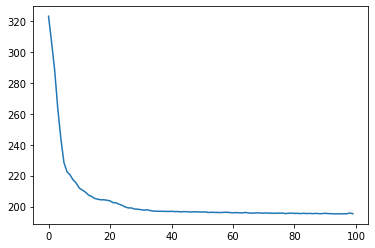

In [28]:
dtensor = torch.FloatTensor(df_test.to_numpy())
device = torch.device("cpu")
model = VAE(num_feats = 20,latent_dims=10).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

rmse,model_out = train_model(data_array=dtensor,model_in=model,
                optimizer_in=optimizer,device_in=device,epochs=100,batch_size=50,mask_in=nan_mask)

In [29]:
from torch.nn import BCELoss

In [30]:
def vae_imputation(model_in,df_true,df_missing,mask_df,feature_type):
    df_out = df_missing.copy()
    rmse_out = []
    loss_out = []
    mask_tensor = torch.FloatTensor(mask_df.to_numpy())
    loss = BCELoss()
    for i in range(1000): 
        model_in.eval()
        recon,_,_ = model_in.forward(torch.FloatTensor(df_out.to_numpy()))
        recon_df  = pd.DataFrame(data=recon.detach().numpy(),columns=mask_df.columns)
        df_out[mask_df==True] = recon_df
        
        for col in feature_type.columns:
            
            if feature_type[col].values == 'cat':
                
                df_out[col]   = df_out[col].round()
                recon_df[col] = recon_df[col].round()
                
        
        loss_out.append(loss((1-mask_tensor)*torch.FloatTensor(df_true.to_numpy()),
                (1-mask_tensor)*torch.FloatTensor(recon_df.to_numpy())).item())
        
        rmse_out.append(RMSE(mask_df.to_numpy()*df_true.to_numpy(),mask_df.to_numpy()*recon_df.to_numpy()))
    return df_out,rmse_out,loss_out

In [31]:
out,rmse,loss_out =vae_imputation(model_in=model_out,
               df_true=df_test,df_missing=df_test_nans_filled,
                         mask_df=nan_mask_df,feature_type=col_type)

In [32]:
model_out

VAE(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (fc11): Linear(in_features=20, out_features=10, bias=True)
  (fc12): Linear(in_features=10, out_features=5, bias=True)
  (fc21): Linear(in_features=5, out_features=10, bias=True)
  (fc22): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (fc31): Linear(in_features=5, out_features=10, bias=True)
  (fc32): Linear(in_features=10, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
)

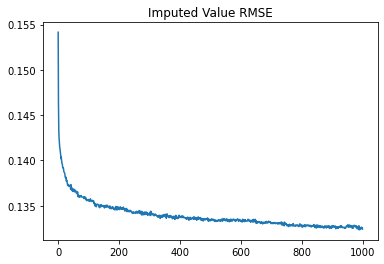

In [41]:
plt.plot(rmse)
plt.title('Imputed Value RMSE')
plt.show()

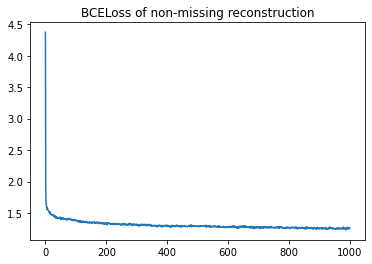

In [42]:
plt.plot(loss_out)
plt.title('BCELoss of non-missing reconstruction')
plt.show()

In [131]:
from sklearn.impute import KNNImputer

In [132]:
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(df_test_with_nans.to_numpy())
knn_imputed = imputer.transform(df_test_with_nans.to_numpy())

In [72]:
RMSE(df_test.to_numpy(),knn_imputed)

0.06681354269047694

In [133]:
RMSE(df_test.to_numpy(),out.to_numpy())

0.12327070894755376

In [134]:
from sklearn.metrics import mean_absolute_error

In [138]:
mean_absolute_error(df_test.to_numpy(),knn_imputed)

0.010079875387575191

In [139]:
mean_absolute_error(df_test.to_numpy(),out.to_numpy())

0.021095549656087665

OUTLIER DETECTION

In [45]:
import seaborn as sns

In [90]:
for col in df_test.columns:
    
    if col_type[col].item() == 'num':
        
        col_sigma = np.std(df_test[col])
        print(np.random.normal(0, 5*col_sigma))
    
    #df_test[col].plot.hist(bins=50)
    #plt.show()

-0.45885271010633216
0.2505002279502625
0.06017651920973859
0.4354019108935024
-0.14438312681638688
0.05228669256574634
-0.24570313338507252
-0.13892068638048816
0.6238141683749482
-0.4248255378266183
-1.3657338861697794


In [97]:
len(wine_df['quality'].unique())


7

In [151]:
probs_list = wine_df['quality'].astype('category').value_counts()/wine_df['quality'].astype('category').value_counts().sum()
tempered_probs_list = probs_list**0.5/np.sum(probs_list**0.5)
print(tempered_probs_list)
print(probs_list)

6    0.315779
5    0.274179
7    0.194779
4    0.087148
8    0.082378
3    0.032478
9    0.013259
Name: quality, dtype: float64
6    0.436509
5    0.329075
7    0.166077
4    0.033246
8    0.029706
3    0.004618
9    0.000770
Name: quality, dtype: float64


In [144]:
cats = list(probs_list.index.values)
np.random.choice(cats,p=probs)

6

In [152]:
wine_df


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,2
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,2
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,2
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


In [156]:
col_type = pd.DataFrame(data=np.array([np.nan]*13).reshape(1,13),columns=wine_df.columns)
for col in wine_df.columns:
    #print(col,len(df_scaled[col].unique()))
    
    if len(wine_df[col].unique()) < 10:
        col_type[col] = 'cat'
    else:
        col_type[col] = 'num'
col_type.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,num,num,num,num,num,num,num,num,num,num,num,cat,cat


In [165]:
for col in wine_df.columns:
    
    if col_type[col].item() == 'num':
        
        col_sigma = np.std(df_test[col])
        print(np.random.normal(0, 5*col_sigma))
        
    if col_type[col].item() == 'cat': 
        probs_list = wine_df[col].astype('category').value_counts()/wine_df[col].astype('category').value_counts().sum()
        tempered_probs_list = probs_list**0.5/np.sum(probs_list**0.5)
        cats  = list(probs_list.index.values)
        probs = tempered_probs_list.values
        print(np.random.choice(cats,p=probs))
    

-0.8480190654167054
-0.23208095903445633
-0.5913336504286023
-0.5619093817219833
-0.1526078040541117
0.022399712331134823
-0.9669440515895755
-0.052397970253784544
0.845350849519833
-0.12317059542064222
-0.773630294503787
7
1


In [194]:
#Corrupt Rows
def corrupt_rows(input_df,coltype_df,percent,num_sigma,alpha): 
    per_corrupt = percent
    num = int(input_df.shape[0]*per_corrupt)
    corrupt_rows = np.random.randint(0,input_df.shape[0],size=num)
    
    df_out = input_df.copy()
    
    for row in corrupt_rows:
    
        for ind,col in enumerate(input_df.columns):
            
            if coltype_df[col].item() == 'num':

                col_sigma = np.std(input_df[col])
                print(df_out.iloc[row,ind])
                print(np.random.normal(0, num_sigma*col_sigma))

            if coltype_df[col].item() == 'cat': 
                probs_list = input_df[col].astype('category').value_counts()/input_df[col].astype('category').value_counts().sum()
                tempered_probs_list = probs_list**alpha/np.sum(probs_list**alpha)
                cats  = list(probs_list.index.values)
                probs = tempered_probs_list.values
                print(df_out.iloc[row,ind])
                print(np.random.choice(cats,p=probs))
    

In [195]:
corrupt_rows(input_df=wine_df,coltype_df=col_type,percent=0.1,num_sigma=2,alpha=1)

6.3
1.5763187685459668
0.26
-0.5563934856642082
0.24
0.07657894745832895
7.2
9.588443859374346
0.039
-0.058195724870999034
38.0
-8.562997867840723
172.0
-163.1220603245829
0.9958
0.01430878174899257
3.49
-0.09294287092653727
0.64
0.3095029486356898
9.7
5.040521353796877
6
8
2
2
7.1
-0.28559210171007066
0.36
0.1320044487785038
0.37
0.5674790803832036
4.8
3.035436713764154
0.019
-0.029959026770251973
39.0
20.828296212020565
114.0
44.539304609637796
0.99036
-0.0035612128488966975
3.08
-0.19791163016321422
0.49
-0.32884984941662226
12.7
2.682958649006344
7
5
2
2
6.5
-2.861917965870794
0.26
0.24133121240126895
0.32
-0.21872869325432207
6.65
0.9772867155286099
0.059
-0.009094225849835668
34.0
-80.99749420247352
104.0
-2.4728719901004452
0.99254
0.003849234546140803
3.18
0.7443571096270689
0.42
0.0477369317383453
11.1
2.3441967614869905
5
7
2
2
7.0
-4.626625049368111
0.36
0.46797291272579555
0.21
-0.4796483603211388
2.4
9.360134731267177
0.086
-0.08434937549772274
24.0
7.97318842373071
69.0
-

7.0
-2.595945132413081
0.12
0.23507323977838118
0.32
0.15440733180144187
7.2
19.516665302264094
0.0579999999999999
0.06717387008416661
22.0
-1.0940657140847265
89.0
112.43530972752728
0.9966
0.004723235001494872
3.29
-0.36106590601761507
0.38
0.5142673510440409
9.2
0.6171531249020106
6
7
2
2
9.9
-2.8179030123222573
0.59
0.656294353852443
0.07
-0.13534109573173517
3.4
-1.7072206161021672
0.102
-0.09272095519430677
32.0
11.987541856457653
71.0
-99.91494060348505
1.0002
0.008609844481333423
3.31
-0.2742652178569764
0.71
-0.5093132119155078
9.8
-0.9744881573233859
5
6
1
2
13.2
5.214239834197167
0.46
0.12270049765119417
0.52
-0.035553573731786324
2.2
5.528608869238525
0.071
0.050127973508413776
12.0
-5.33074629992618
35.0
-51.161286746064675
1.0006
-0.0014039655217784844
3.1
0.6437678098897106
0.56
-0.23913422433714723
9.0
-1.829136173564681
6
6
1
2
7.7
3.8810508986365657
0.28
-0.13713113283793799
0.3
0.07727818629167606
2.0
3.973470752743824
0.062
0.010812710868099523
18.0
-0.5643567431627

3.22
0.3325317913731049
0.68
0.22306351979992625
11.7
-2.788241517648365
6
5
1
2
6.2
-1.6008041127258317
0.36
0.3411720173002577
0.22
0.3694098371072504
5.25
-4.408678471276014
0.038
0.04005566331422937
44.0
3.249343940581779
145.0
14.30658545778136
0.99184
-0.002512463432560425
3.22
-0.07055805104251209
0.4
0.09596965893616025
11.2
2.6065237160179673
6
6
2
2
9.2
-0.6330559655871177
0.18
-0.3743050606874391
0.49
0.11624015254992137
1.5
8.387851522478206
0.0409999999999999
0.12397738837656228
39.0
12.470789273864904
130.0
54.469772390921506
0.9945
0.004487838416112145
3.04
0.011307181670809598
0.49
-0.37072625194512066
9.8
-1.909192078410641
7
6
2
2
7.5
0.443300073099189
0.21
0.0984140873026187
0.68
-0.026595229286770557
10.9
11.995672150632881
0.045
0.030152570861211644
38.0
-15.03882833956912
133.0
93.40675657473813
0.9978
-0.006904382126214959
3.0
-0.19890717570493405
0.36
0.0013487666368144895
8.7
-1.8744885538873641
5
5
2
2
6.6
-0.7861966368177425
0.41
0.4128682440671374
0.16
0.076

5
5
1
2
6.6
1.811295236363614
0.61
0.12412041011740624
0.01
-0.20989382401628026
1.9
-18.561469229291518
0.08
0.17209948769333988
8.0
30.185186533616864
25.0
-157.5975184046812
0.99746
0.006471586265136402
3.69
-0.014373176522133421
0.73
0.45388307125001526
10.5
-1.2186281727170236
5
6
1
1
6.3
3.5508840652076565
0.67
0.6013456505503604
0.48
-0.17029025888313493
12.6
9.030130573194752
0.052
0.10431526763026401
57.0
-29.301887760117616
222.0
163.96776802439845
0.9979
0.007812556260874967
3.17
-0.39024735236227764
0.52
0.03812333182238731
9.3
4.181513740368473
6
5
2
1
6.9
-1.1961774997877739
0.23
0.8066978664376658
0.33
-0.05487583255919429
12.8
5.847206761317545
0.0559999999999999
0.12093902524755444
44.0
18.665680197444388
169.0
26.180627896055025
0.998
0.004655247183291737
3.42
-0.8727290621098621
0.42
0.5913471685550249
9.8
0.31056306206734874
6
5
2
2
11.5
2.217272686965167
0.315
0.21932901220910064
0.54
0.08955683644933579
2.1
-4.584469983338896
0.084
-0.126737015435146
5.0
22.182050

6
7
1
2
7.1
-0.14915839950237825
0.44
-0.5962252098666865
0.27
0.2750297736984753
8.4
1.7611638884874323
0.057
-0.07033250846882451
60.0
27.081062369289768
160.0
-53.81114554701433
0.99257
0.0023781285335703448
3.16
-0.2736252276825434
0.36
-0.566412687374785
11.8
-1.9825200109848793
6
8
2
2
6.8
-1.1826663519365208
0.16
0.49933701658013885
0.18
0.07072161699466122
1.8
9.524720923147918
0.046
-0.03762402363805626
31.0
47.76319948001006
114.0
6.8124142861490435
0.99226
0.005597555856605238
3.27
0.36583687334562587
0.55
-0.3170506382208579
10.8
1.7773287900144001
6
6
2
2
6.3
3.2450129284080584
0.3
0.47445940569282974
0.19
0.22772587239351424
7.7
-6.081214822206643
0.049
-0.0002907391698728925
47.0
-42.95011293240698
184.0
2.665129392732266
0.99514
0.002584080984616643
3.22
0.21015105974403175
0.48
0.03381913794655094
9.5
0.019633668320002125
5
6
2
2
6.4
-0.6403515536985471
0.22
0.39090856735876445
0.34
-0.23853979259573188
1.4
19.605129481098274
0.023
-0.016888365105004535
56.0
69.3205659

0.99825
-0.005887551816778858
3.37
0.09570972078855634
0.49
-0.5383451070440286
9.4
3.1787230442527576
6
6
2
1
6.2
0.5644094805282429
0.44
0.30339475141660943
0.39
-0.30403069918623954
2.5
-7.663492635074948
0.077
0.06446129746534293
6.0
-11.821114675750454
14.0
-40.27916371589149
0.99555
-0.0016903260372168724
3.51
-0.07956626870334552
0.69
0.022696011967450268
11.0
2.553660925494033
6
6
1
1
6.2
2.7693812502582054
0.35
0.5682416585374716
0.29
0.23503675506945085
3.9
6.974193145990527
0.0409999999999999
-0.01768132351129269
22.0
74.2643041061979
79.0
161.32412072491348
0.99005
-0.013497477113804368
3.1
0.36216348695766104
0.59
-0.09812489844029154
12.067
0.9059890982269894
6
6
2
2
7.0
-1.2996816718893938
0.32
0.6453211041482452
0.34
0.2665513129088428
1.3
4.842265075118631
0.042
0.053487137657039975
20.0
-1.470812288599384
69.0
106.25508556606312
0.9912
0.009301110335748356
3.31
-0.009351001661993203
0.65
0.018905044202837097
12.0
-0.9962027463489191
7
6
2
2
9.1
0.5335750023043446
0.28

5
5
1
1
6.3
0.6909050051536465
0.36
-0.08104681029809596
0.28
-0.0012937773846342002
2.5
-3.82457435012767
0.035
0.02381403148875519
18.0
15.60257001604043
73.0
152.89451540335907
0.98868
0.0007963669855841794
3.1
-0.0825766063294198
0.47
0.21105078656103932
12.8
0.6382711031629278
7
5
2
2
8.0
-0.9547492946427255
0.25
0.1918762108666038
0.27
-0.3114737970324643
9.7
10.921529807651469
0.036
0.10483162584802684
15.0
37.57688077127995
85.0
52.288094288934275
0.99406
-0.0018005203495618709
2.99
-0.48403400443933736
0.36
-0.0635373190091352
11.2
2.38407346280251
6
6
2
2
8.0
-3.8564390328863287
0.58
0.3871655937413107
0.28
0.33407696506154905
3.2
-3.723702125575569
0.066
0.035450277426221956
21.0
-29.01675971865329
114.0
-192.5369402453972
0.9973
0.0014608620190088746
3.22
0.1458308080320892
0.54
-0.5775337820875227
9.4
1.566159128632029
6
5
1
2
5.8
1.3983336911071067
0.31
0.1667733417183907
0.31
-0.15646383760006904
7.5
-0.6952210421021552
0.052
-0.060446727917826626
55.0
-2.62254615795698


2
1
6.8
-1.6251005600628472
0.3
0.10990284960488918
0.27
-0.3533275445685904
11.6
3.989072708515511
0.0279999999999999
0.05363113624539726
22.0
21.30314391884354
97.0
-225.47720937025366
0.99314
-0.0005632793224750526
2.96
0.5628255196669297
0.38
0.4812702430552985
11.7
-0.45470683173132753
6
8
2
2
7.3
4.211088130410295
0.66
0.05363611006830615
0.001
-0.09329025248482323
2.0
11.430639187542697
0.084
-0.00466828195537542
6.0
-26.571344920163774
23.0
13.170887012978504
0.9983
0.00956658001161379
3.61
-0.20337032671627192
0.96
-0.35368844614470396
9.9
4.1093493489545665
6
5
1
1
7.4
-0.2127331781330186
0.33
-0.5932680145576148
0.26
0.2398670436159839
15.6
-3.477428720883811
0.049
0.012716847775671988
67.0
38.46151304230364
210.0
44.056934631870284
0.99907
-0.0031528479500445425
3.06
-0.43913230714383983
0.68
0.3361743239212717
9.5
1.5024743901015645
5
6
2
2
6.8
-1.4197540173874101
0.32
0.4357908054902317
0.18
0.21929116431416298
7.5
-3.3184361601822987
0.0409999999999999
0.0317223243530209

5
6
2
1
6.1
2.9925162871823425
0.34
-0.03459220479823891
0.46
0.09034907996774615
4.7
-4.226358783942489
0.0289999999999999
0.0669429607346834
21.0
-12.542170618278124
94.0
-34.231022141768925
0.991
0.001473278619464788
3.29
-0.0437511781406477
0.62
-0.12770918653296348
12.3
-2.059749131444192
6
6
2
1
11.1
3.7919760726139247
0.45
-0.13922338380255234
0.73
-0.030512350719265342
3.2
-1.9728155368342974
0.066
-0.12041011316053185
6.0
16.0259011565469
22.0
95.12302105353628
0.9986
-0.005528788839641101
3.17
-0.0750701419857824
0.66
-0.07924274391640863
11.2
2.890597658367883
6
8
1
2
7.5
-1.7107908092302597
0.57
0.332418086728321
0.08
0.2516050080774173
2.6
0.21304911097060106
0.089
-0.055077254572815
14.0
53.20625711511246
27.0
-0.6473936746794137
0.99592
-0.006915903639277851
3.3
0.2972747906726858
0.59
0.07887045059260393
10.4
1.016552176012331
6
6
1
2
6.9
1.6011943865419553
0.4
0.04158865501706772
0.56
-0.27166535440241685
11.2
-1.1730838482602988
0.043
0.14779348550672064
40.0
-34.9065

2
2
5.6
3.789532993336009
0.66
-0.37761638993534097
0.001
0.26728329043603094
2.2
6.638684544037004
0.087
-0.003690819853861317
3.0
32.807554216702115
11.0
117.49429583916391
0.99378
-0.007809557711236628
3.71
0.3019946094383806
0.63
0.035997871624722046
12.8
-0.7607121907467084
7
6
1
1
6.6
0.9646246559712
0.32
-0.027935903078152902
0.22
-0.2187285989569751
16.7
12.164808328090126
0.046
-0.05723191271301705
38.0
-42.96433062274719
133.0
50.18502440148175
0.9979
-0.01134959257573494
3.22
0.3283230782616281
0.67
0.23714023724225108
10.4
0.922753695764091
6
7
2
1
8.9
-1.109368247623685
0.13
0.15623246715841094
0.49
-0.08186459392311699
1.0
-1.0934830384736092
0.0279999999999999
-0.007075530622890777
6.0
35.22718867848741
24.0
30.68473357069957
0.9926
-0.006187671396116298
2.91
-0.4827131442925943
0.32
-0.32643804973792584
9.9
2.0040752695343533
5
4
2
2
6.4
-4.347120925395085
0.32
0.8427655942185502
0.23
-0.27171217429527406
16.2
-0.8524862776586545
0.055
-0.026281581023772982
36.0
-29.274

6
7
2
2
7.4
-1.8877058771071185
0.24
-0.1372746921188985
0.26
0.12523046950921254
1.6
-3.3665428113640514
0.0579999999999999
0.0022368037633185116
53.0
16.964100882894876
150.0
-25.41531063848573
0.9936
-0.008191538345135354
3.18
0.009945033871960853
0.5
0.24730115988192528
9.9
-0.010598950677485395
7
6
2
2
5.9
-2.0545998863487247
0.48
-0.10552268362258
0.3
0.18078724333268165
1.5
6.200943196453564
0.037
0.10195738694816593
19.0
0.29447948792182477
78.0
20.274851399485183
0.99057
0.0049791252989062305
3.47
0.12120331111794365
0.42
0.4519775952070254
11.9
-0.027754107931580663
7
5
2
2
6.7
0.11603115020365329
0.24
0.49535705753234754
0.41
-0.11589358507692783
8.7
-1.0815742331881364
0.036
-0.009570853788967385
29.0
-2.209783785863053
148.0
24.708284780821554
0.9952
-0.0015270337573055194
3.22
0.2523626395020303
0.62
-0.05720466527640731
9.9
-1.7385217879674817
6
5
2
2
15.9
2.658638546197242
0.36
0.22327747573618104
0.65
0.10486825179829337
7.5
-1.660702257464413
0.096
0.04513660398300320

208.0
-39.35283651172281
0.99272
-0.002874091589956669
3.18
0.15706452771968427
0.46
-0.10307773605145001
9.9
0.5539002443438242
6
5
2
1
6.9
2.4403671805685967
0.34
0.42379557069669427
0.3
0.38663612908723266
4.7
-10.161178080306152
0.0289999999999999
0.20073447688036392
34.0
-2.457971846575223
148.0
37.014775963528415
0.99165
-0.0023331348466601206
3.36
0.017229347107214705
0.49
-0.2151997197979226
12.3
-0.2595950656029848
7
7
2
2
7.8
2.6454132416355343
0.21
-0.41246830991982764
0.34
-0.5302198036466983
11.9
-11.769657513150163
0.039
0.05786744315940902
55.0
87.19206614674775
140.0
301.96446527715113
0.9959
0.005349907511467319
3.02
-0.034379813493883034
0.31
-0.5859422224290467
10.3
0.8390595366643624
6
5
2
2
6.3
-1.9561863466607454
0.33
0.3314934797618473
0.2
-0.14427279574421592
5.8
7.371815131541664
0.04
-0.03331250199829959
24.0
4.019270227098388
144.0
4.398502284084418
0.99425
-0.010881537315692616
3.15
-0.060927225948264364
0.63
0.15273644356811017
9.9
0.34876212101726556
5
6
2

9.6
0.6931448293069001
6
6
1
2
8.1
0.4712747944004682
0.17
-0.2657579202448988
0.44
0.6046667268338356
14.1
-4.58462137442392
0.053
0.0026988953213143855
43.0
-18.87608739334454
145.0
83.8852856711243
1.0006
-0.007728841903145651
3.28
-0.36039127790216946
0.75
-0.2054068105718454
8.8
-2.8304677467093415
8
5
2
2
7.0
0.8493697075549417
0.14
0.24207589768984145
0.41
-0.20096328037661437
0.9
-20.850610839010912
0.037
0.02301563209380992
22.0
-25.498867195648828
95.0
159.54560563361522
0.9914
-0.0005815213034083782
3.25
-0.018718735297334404
0.43
0.05541990868889796
10.9
-2.7189878830110836
6
6
2
2
7.6
2.5317477484259867
0.17
-0.011497805791579697
0.36
-0.21770791695543476
4.5
-2.1848214290056824
0.042
0.031143663509301853
26.0
45.00236303855509
102.0
-25.900637227463058
0.99427
0.0032851269507400433
3.09
-0.14751473970076487
0.47
0.25765848977333744
9.5
-0.14397945222064673
5
7
2
2
11.1
0.18633064875733812
0.31
0.0667701100307248
0.53
-0.23486890301195337
2.2
5.301394841112409
0.06
0.04292

1.1
-11.031700962019602
0.027
-0.021757763302286157
16.0
-74.12887038327291
63.0
-97.70157182490343
0.9937
0.0004866490240205567
3.37
-0.32994860420023164
0.4
-0.1319737526047156
9.9
3.1050423238245277
5
6
2
2
7.6
-4.66451162310637
0.32
0.15478336931309872
0.58
-0.18814392460117635
16.75
-8.922571957328792
0.05
-0.14227716082102268
43.0
36.33507303397091
163.0
88.79475903041285
0.9999
0.005583878231071651
3.15
-0.37525379649258434
0.54
-0.20630340665591695
9.2
0.8299754003015833
5
5
2
1
6.3
1.6274954960130303
0.26
0.4530300800563642
0.49
0.1337592389099515
1.5
10.733109641307372
0.052
0.0009580235619254703
34.0
13.758655070572653
134.0
134.95276606495915
0.9924
0.0031369508655419718
2.99
0.7311683461866213
0.61
0.3759898089244138
9.8
-3.669885590042633
6
7
2
2
7.1
0.8664852746026991
0.46
0.21261582429880707
0.2
0.00034763609916207245
1.9
-3.725204834322604
0.077
-0.006965516965045078
28.0
0.4136361658955692
54.0
47.190335905044336
0.9956
-0.004364049207500287
3.37
0.10519862934765523
0

0.27
-0.35319799092364274
0.25
-0.22949086421657644
5.0
7.472692644265869
0.024
-0.15737317971767928
52.0
-59.84465010734077
99.0
-44.86505592702659
0.9925
-0.004029287391341827
2.87
-0.29206415564249777
0.49
-0.17106633436572075
11.4
-4.402806703112998
5
5
2
2
7.1
2.3730921710041697
0.27
0.5477791892696021
0.27
0.12446668236440202
10.4
13.151975471468786
0.0409999999999999
-0.1066976004796635
26.0
-63.15363949583926
114.0
52.02277961811113
0.99335
0.008584832454197317
3.04
0.17803224121371594
0.52
0.09966730894005309
11.5
2.069905802077594
7
4
2
2
6.1
2.750615611297886
0.28
0.40700114862347764
0.32
-0.214199485978832
2.5
3.4229584596176728
0.042
0.121657877243279
23.0
15.449464385763262
218.5
-232.08139757815138
0.9935
-0.00344696291354577
3.27
-0.4357883813513291
0.6
0.7530447812670795
9.8
-0.8401478049765567
5
7
2
2
6.8
2.46079899526458
0.27
0.010464685251336292
0.24
0.043747261167396495
4.6
-2.8124133582868924
0.098
0.05960242030501142
36.0
-14.483952547885844
127.0
149.36459874833

2
1
9.8
-0.5980468887493952
0.44
-0.016986839232356978
0.4
-0.1606690711389419
2.8
-4.753796084628424
0.036
0.047198832178090705
35.0
14.587595200549515
167.0
-106.59513760238424
0.9956
0.003113990620394416
2.97
0.22850040624071816
0.39
-0.3616146101492368
9.2
-1.628249612872278
5
8
2
2
6.0
-0.9818217974608221
0.32
-0.6135070505538724
0.3
-0.19892770745186017
1.9
-5.802103148271504
0.033
-0.08534695375737295
41.0
5.443615392561591
142.0
-113.65038321682657
0.98912
0.00453829264330704
3.29
-0.6146038409865993
0.42
-0.6783502957415118
12.8
0.5571711288063389
7
7
2
2
7.0
1.0004990494527992
0.2
0.43439649170195604
0.37
-0.006073750847202821
2.0
-14.906919966987298
0.03
-0.07839582116469408
26.0
-7.337447234006343
136.0
-47.24154867981488
0.9932
0.007924871089895048
3.28
-0.07282333273946236
0.61
-0.5508954661891946
10.2
-1.0411444504175342
6
6
2
2
6.9
3.773797296086798
0.27
0.46671287555096697
0.25
0.08110089758182026
7.5
-8.892964471102964
0.03
0.08051644006228019
18.0
-25.334232535628065

21.0
63.747848650672665
0.9976
0.009330298433526138
3.25
-0.12168869989759716
1.02
0.42936397592718395
10.8
-0.3116830864221754
7
5
1
1
6.8
0.06676156712243857
0.22
0.09321227905679974
0.49
-0.15089493726274758
0.9
15.913579268592432
0.052
0.054612808333947487
26.0
-29.68701192552699
128.0
-46.82423338294827
0.991
-0.0027438916789148614
3.25
-0.17859521010561608
0.35
-0.15810980731080412
11.4
-0.5010680121550513
6
8
2
1
7.0
-2.952768027275098
0.15
0.01886772232655666
0.28
-0.3035950182851164
14.7
-6.795613801690337
0.051
-0.07843589685492006
29.0
13.359841365500271
149.0
62.430555220352595
0.99792
-0.0004915767652493872
2.96
0.0521499667173719
0.39
-0.5071015329115738
9.0
-1.2200081898514614
7
5
2
2
7.2
0.26728100298885477
0.28
-0.30061159791823305
0.54
-0.615036594109797
16.7
8.472642245371597
0.045
-0.02962700752870413
54.0
-4.772509672553674
200.0
17.77929473369802
0.999
0.007526133214828968
3.08
0.07603426637097783
0.49
0.3855295709967538
9.5
-0.13457132320449824
6
7
2
2
7.7
0.9771

6
6
2
2
8.2
0.36796760067925144
0.64
0.0029030249433341683
0.27
0.13148139600219544
2.0
-10.429575775692967
0.095
-0.0994027058182203
5.0
3.401687553990974
77.0
71.88852657645187
0.99747
0.0012888749818045881
3.13
-0.2586971370866936
0.62
-0.6575224556079334
9.1
2.103964813260133
6
6
1
1
5.4
1.3514861550521102
0.53
-0.033331045492828844
0.16
-0.19826729388168451
2.7
-16.178347816789646
0.036
-0.007164593602178533
34.0
-4.294700577331131
128.0
-5.700263125380856
0.98856
0.004760660691160454
3.2
0.160239323301383
0.53
-0.29913234240820835
13.2
1.8605648457000845
8
5
2
2
8.7
-2.7354237048679044
0.54
-0.3619307713433791
0.26
-0.05894196570305946
2.5
-0.08552277053566774
0.0969999999999999
0.029381000182908068
7.0
-37.667765249455066
31.0
82.93899668082273
0.9976
-0.005825243279644485
3.27
0.24400609189884226
0.6
-0.2739169278222916
9.3
1.063018891073095
6
5
1
2
6.5
-3.8616555292345964
0.35
-0.3467778374762342
0.38
0.16311490467246564
7.4
9.744255294217169
0.036
-0.11421796922646565
20.0
24

19.0
-37.09776427495716
130.0
-44.770871849091264
0.99176
-0.003728260989910443
3.14
0.14016309353330625
0.49
-0.3501875276296274
12.8
1.0107766582984534
7
5
2
1
8.1
-1.1867426455520171
0.78
0.5896722540511206
0.1
0.08641393434401286
3.3
9.221222023435411
0.09
-0.1193972634145543
4.0
62.57555209117609
13.0
-257.7391741941503
0.99855
-0.001405403752061937
3.36
-0.003222891461298241
0.49
-0.16137065884418988
9.5
0.8370121735977541
5
5
1
1
